In [1]:
import matplotlib.pyplot as plt
import numpy as np

from superfv import OutputLoader, plot_1d_slice

In [2]:
def compute_M(idx, mesh, w, gamma, v0, t):
    x, y, _ = mesh.get_cell_centers()
    rho = w[idx("rho")]
    vx = w[idx("vx")] - v0
    vy = w[idx("vy")]
    P = w[idx("P")]

    x = (x - v0 * t) % 1
    xc = x - 0.5
    yc = y - 0.5
    r = np.sqrt(xc**2 + yc**2)

    v_phi = vx * (-yc / r) + vy * (xc / r)

    cs2 = gamma * P / rho
    cs = np.sqrt(np.maximum(cs2, 0.0))

    M = np.abs(v_phi) / cs

    return M


def compute_M_func(gamma, v0, t, M_max):
    def f(idx, mesh, w):
        M = compute_M(idx, mesh, w, gamma, v0, t)
        return M / M_max

    return f

Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/short-debug/v0_5.0/p3/M_max_0.001"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/short-debug/v0_5.0/p3/M_max_0.001"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/short-debug/v0_5.0/p7/M_max_0.001"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/short-debug/v0_5.0/p7/M_max_0.001"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/short-debug/v0_5.0/MUSCL-Hancock/M_max_0.001"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/short-debug/v0_5.0/MUSCL-Hancock/M_max_0.001"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/short-debug/v0_5.0/MUSCL-Hancock/M_max_0.001"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/short-debug/v0_5.0/MUSCL-Hancock/M_max_0.001"


/home/jp7427/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.505208
  warnings.warn(
/home/jp7427/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.505208
  warnings.warn(
/home/jp7427/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.505208
  warnings.warn(
/home/jp7427/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.505208
  warnings.warn(
/home/jp7427/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.505208
  warnings.warn(
/home/jp7427/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.5052

Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/short-debug/v0_5.0/ZS3/M_max_0.001"


/home/jp7427/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.505208
  warnings.warn(


Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/short-debug/v0_5.0/ZS3/no_v/M_max_0.001"


/home/jp7427/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.505208
  warnings.warn(


Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/short-debug/v0_5.0/ZS7/M_max_0.001"


/home/jp7427/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.505208
  warnings.warn(


Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/short-debug/v0_5.0/ZS7/no_v/M_max_0.001"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/short-debug/v0_5.0/MM3/1rev/no_v/no_delta/rtol_1e-5/M_max_0.001"


/home/jp7427/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.505208
  warnings.warn(
/home/jp7427/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.505208
  warnings.warn(


Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/short-debug/v0_5.0/MM7/1rev/no_v/no_delta/rtol_1e-5/M_max_0.001"


/home/jp7427/Desktop/superfv/superfv/visualization.py:43: UserWarning: Cell-centered coordinate 0.5 not exactly matched in mesh; using nearest: 0.505208
  warnings.warn(


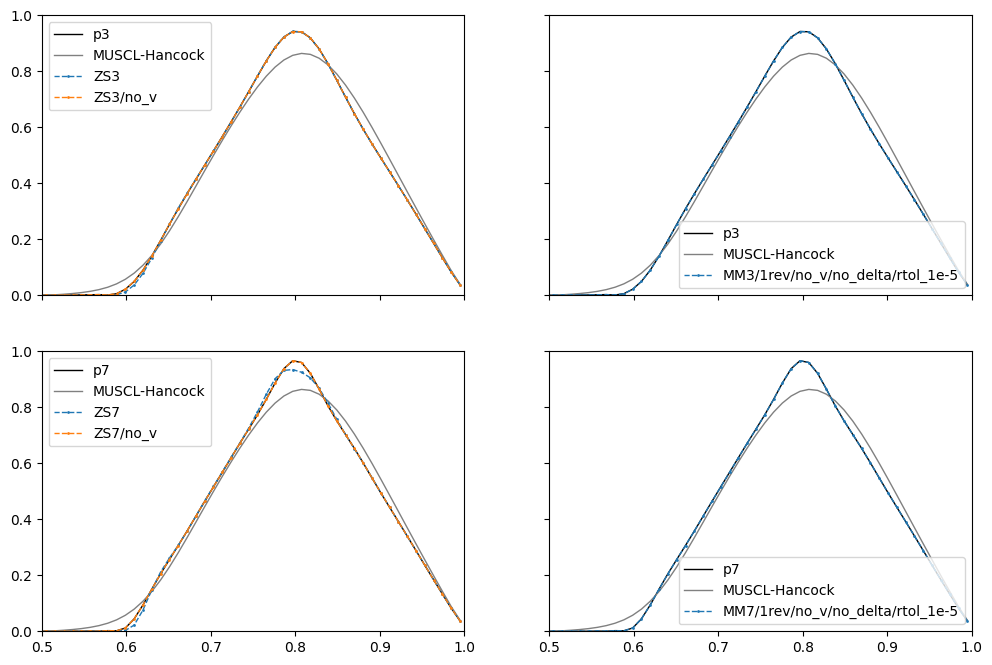

In [6]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 8))
axs[0, 0].set_xlim(0.5, 1)
axs[0, 0].set_ylim(0, 1)

base_path = "/scratch/gpfs/jp7427/out/gresho-vortex/short-debug/v0_5.0/"


def plot_mach(name, ax, style=dict()):
    sim = OutputLoader(f"{base_path}{name}/M_max_0.001/")
    t = sim.minisnapshots["t"][-1]

    plot_1d_slice(
        sim,
        ax,
        "w",
        t=t,
        y=0.5,
        multivar_func=compute_M_func(5 / 3, 5.0, t, 0.001),
        cell_averaged=True,
        label=name,
        **style,
    )


common_style = dict(linewidth=1)

plot_mach("p3", axs[0, 0], dict(color="k", **common_style))
plot_mach("p3", axs[0, 1], dict(color="k", **common_style))
plot_mach("p7", axs[1, 0], dict(color="k", **common_style))
plot_mach("p7", axs[1, 1], dict(color="k", **common_style))

plot_mach("MUSCL-Hancock", axs[0, 0], dict(color="grey", **common_style))
plot_mach("MUSCL-Hancock", axs[0, 1], dict(color="grey", **common_style))
plot_mach("MUSCL-Hancock", axs[1, 0], dict(color="grey", **common_style))
plot_mach("MUSCL-Hancock", axs[1, 1], dict(color="grey", **common_style))

style = dict(markersize=1, marker="o", mfc="none", linestyle="--", **common_style)

plot_mach("ZS3", axs[0, 0], style)
plot_mach("ZS3/no_v", axs[0, 0], style)

plot_mach("ZS7", axs[1, 0], style)
plot_mach("ZS7/no_v", axs[1, 0], style)

plot_mach("MM3/1rev/no_v/no_delta/rtol_1e-5", axs[0, 1], style)

plot_mach("MM7/1rev/no_v/no_delta/rtol_1e-5", axs[1, 1], style)

axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()

In [6]:
fig.savefig("gresho-debug.pdf", bbox_inches="tight")

In [ ]:
def get_quantity_list(sim, quantity="ke", p=None):
    idx = sim.variable_index_map
    mesh = sim.mesh

    v0 = 5.0

    def get_KE(t, snapshot):
        w = snapshot["w"]
        rho = w[idx("rho")]
        vx = w[idx("vx")] - v0
        vy = w[idx("vy")]
        return np.mean(0.5 * rho * (vx**2 + vy**2))

    def get_L(t, snapshot):
        u = snapshot["ucc"]
        x, y, _ = mesh.get_cell_centers()
        xc = (x - v0 * t) % 1 - 0.5
        yc = y - 0.5
        px = u[idx("mx")] - u[idx("rho")] * v0
        py = u[idx("my")]
        return np.mean(xc * py - yc * px)

        # x, y, _ = mesh.get_cell_centers()

        # d = mesh.x_slab_depth
        # ninterpolations = -(-(p + 1) // 2)

        # nodes, weights = np.polynomial.legendre.leggauss(-(-(p + 1) // 2))
        # nodes /= 2
        # weights /= 2

        # u = snapshot["u"]
        # _u_ = np.empty((u.shape[0], mesh._nx_, mesh._ny_, mesh._nz_))
        # _u_[:, d:-d, d:-d, :] = u
        # apply_bc(np, _u_, pad_width=(d, d, 0), mode=(("periodic", "periodic"), ("periodic", "periodic"), ("none", "none")))

        # _u_GL_nodes_ = np.empty((*_u_.shape, 20))
        # _buffer_ = _u_GL_nodes_.copy()
        # fv_interpolate(np, _u_, {"x": nodes.tolist(), "y": nodes.tolist()}, p, out=_u_GL_nodes_, buffer=_buffer_)

        # u = _u_GL_nodes_[:, d:-d, d:-d, :, :ninterpolations**2]
        # px = u[idx("mx")] - u[idx("rho")] * v0
        # py = u[idx("my")]

        # L_nodes = (x - 0.5) * py - (y - 0.5) * px

        # Weights = (weights[:, np.newaxis] * weights[np.newaxis, :]).flatten()[*([np.newaxis,] * 5)]

        # L = np.sum(L_nodes * Weights, axis=4)

        # return np.mean(L)

    t_values = [t for t, _ in sim.snapshots]

    get_q = {"ke": get_KE, "l": get_L}[quantity]

    return t_values, [get_q(t, sim.snapshots(t)) for t in t_values]

In [26]:
KE_ana = 25 / 4 * (0.2**4)
KE_ana += 2 * (0.4**2) - 20 / 3 * (0.4**3) + 25 / 4 * (0.4**4)
KE_ana -= 2 * (0.2**2) - 20 / 3 * (0.2**3) + 25 / 4 * (0.2**4)
KE_ana *= np.pi
KE_ana

0.0837758040957277

Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/short-debug/v0_5.0/MUSCL-Hancock/M_max_0.001"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/short-debug/v0_5.0/ZS3/no_v/M_max_0.001"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/short-debug/v0_5.0/MM3/1rev/no_v/no_delta/rtol_1e-5/M_max_0.001"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/short-debug/v0_5.0/ZS7/no_v/M_max_0.001"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/short-debug/v0_5.0/MM7/1rev/no_v/no_delta/rtol_1e-5/M_max_0.001"


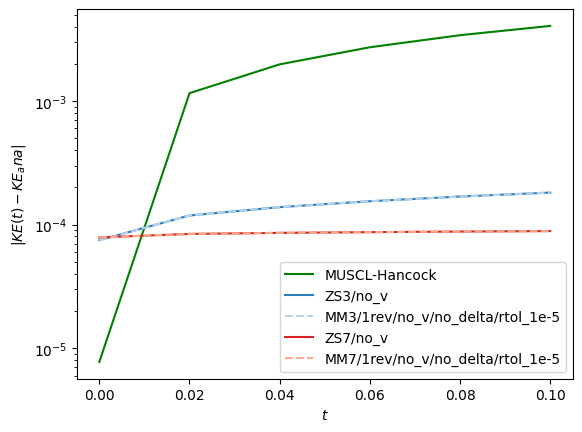

In [25]:
base_path = "/scratch/gpfs/jp7427/out/gresho-vortex/short-debug/v0_5.0/"

fig, ax = plt.subplots()

ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$|KE(t) - KE_{\text{ana}}|$")
ax.set_yscale("log")

cmap1 = plt.get_cmap("Blues")
cmap2 = plt.get_cmap("Reds")


def plot(name, ax, style):
    t_values, KE_values = get_quantity_list(
        OutputLoader(f"{base_path}{name}/M_max_0.001/")
    )
    ax.plot(t_values, np.abs(np.array(KE_values) - KE_ana), label=name, **style)


plot("MUSCL-Hancock", ax, dict(color="green"))
plot("ZS3/no_v", ax, dict(color=cmap1(0.7)))
plot("MM3/1rev/no_v/no_delta/rtol_1e-5", ax, dict(color=cmap1(0.3), linestyle="--"))
plot("ZS7/no_v", ax, dict(color=cmap2(0.7)))
plot("MM7/1rev/no_v/no_delta/rtol_1e-5", ax, dict(color=cmap2(0.3), linestyle="--"))

ax.legend()

In [3]:
L_ana = 5 / 4 * (0.2**4)
L_ana += 2 / 3 * (0.4**3) - 5 / 4 * (0.4**4)
L_ana -= 2 / 3 * (0.2**3) - 5 / 4 * (0.2**4)
L_ana *= 2 * np.pi
L_ana

0.05864306286700945

Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/v0_5.0/MUSCL-Hancock/M_max_0.001"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/v0_5.0/ZS3/M_max_0.001"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/v0_5.0/ZS3/no_v/M_max_0.001"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/v0_5.0/ZS7/M_max_0.001"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/v0_5.0/ZS7/no_v/M_max_0.001"


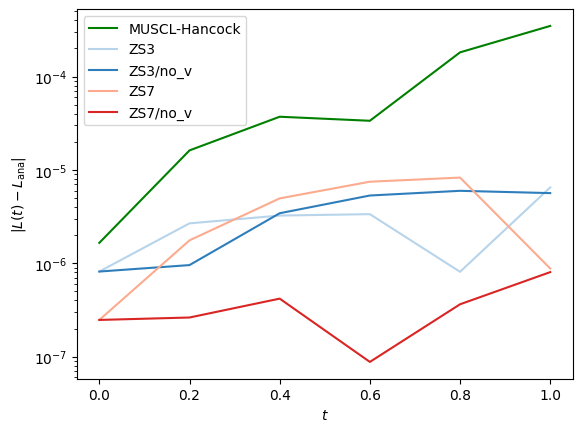

In [6]:
base_path = "/scratch/gpfs/jp7427/out/gresho-vortex/v0_5.0/"

fig, ax = plt.subplots()

ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$|L(t) - L_{\text{ana}}|$")
ax.set_yscale("log")

cmap1 = plt.get_cmap("Blues")
cmap2 = plt.get_cmap("Reds")


def plot(name, p, ax, style):
    t_values, L_values = get_quantity_list(
        OutputLoader(f"{base_path}{name}/M_max_0.001/"), "l", p
    )
    ax.plot(t_values, np.abs(np.array(L_values) - L_ana), label=name, **style)


plot("MUSCL-Hancock", 1, ax, dict(color="green"))
plot("ZS3", 3, ax, dict(color=cmap1(0.3)))
plot("ZS3/no_v", 3, ax, dict(color=cmap1(0.7)))
# plot("MM3/1rev/rtol_1e-2", 3, ax, dict(color=cmap1(0.3), linestyle='--'))
plot("ZS7", 7, ax, dict(color=cmap2(0.3)))
plot("ZS7/no_v", 7, ax, dict(color=cmap2(0.7)))
# plot("MM7/1rev/rtol_1e-2", 7, ax, dict(color=cmap2(0.3), linestyle='--'))

ax.legend()